In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold

import tensorflow as tf
from tensorflow import keras

# Keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM, Bidirectional
from tensorflow.keras import utils
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim
from gensim.models import phrases

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools
import string

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [ ]:
# DATASET
DATASET_COLUMNS = ["target", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

#TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 500
W2V_WINDOW = 7
W2V_EPOCH = 4
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 500
EPOCHS = 5
BATCH_SIZE = 8

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [ ]:
dataset_path = "/content/drive/My Drive/New Data/processed_data_less.csv"
print("Open file:", dataset_path)
df = pd.read_csv(dataset_path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS, skiprows=1)
df.head

Open file: /content/drive/My Drive/New Data/processed_data_less.csv


<bound method NDFrame.head of         target                                               text
296746       1  ugh ive been having this problem for the past ...
377066       1  suddenly everythings hard and confusing again ...
433411       1  i didn't think chester's death would hit me th...
55116        1  your words walk me to the station,they sit nex...
379076       1  i've spent the last years of my life depressed...
...        ...                                                ...
169449       0  it feels like when im hungry, after a while it...
290057       0  that ethiopia uses a different new year, and t...
2552         0  reddit, what are some of your favorite life-ru...
420625       0  only two-thirds of american millennials believ...
219838       0  i have been reading lately about this matter o...

[529438 rows x 2 columns]>

In [ ]:
print("Dataset size:", len(df))

Dataset size: 529438


In [ ]:
print("Dataset size:", len(df))

Dataset size: 529438


**NOTE**: PLease allow your browser to allow show pop-ups by sites as show below 

In [ ]:
decode_map = {0: "Not_Depressed", 1: "Depressed"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [ ]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 149 ms, sys: 751 µs, total: 150 ms
Wall time: 150 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

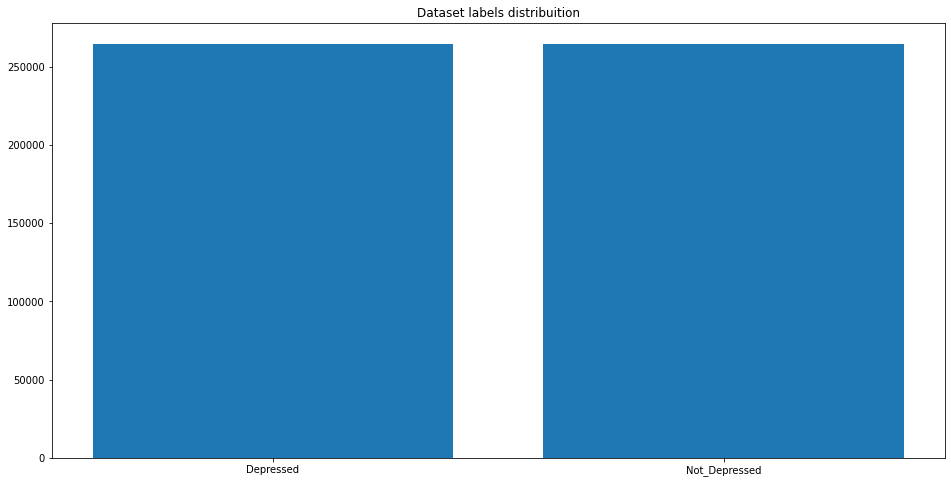

In [ ]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [ ]:
import nltk
nltk.download('stopwords')
stop_words = stopwords.words("english")
stop_words.remove('not')
stemmer = SnowballStemmer("english")
print(stop_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'ea

In [ ]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = str(text).lower().strip().translate(str.maketrans("", "", string.punctuation))
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
        # tokens.append(token)
    return tokens

In [ ]:
df.text=df.text.apply(lambda row:preprocess(row))
df

,target,text
296746,Depressed,"[ugh, ive, problem, past, years, kept, getting..."
377066,Depressed,"[suddenly, everythings, hard, confusing, tell,..."
433411,Depressed,"[didnt, think, chesters, death, would, hit, hard]"
55116,Depressed,"[words, walk, stationthey, sit, next, train, f..."
379076,Depressed,"[ive, spent, last, years, life, depressed, ive..."
...,...,...
169449,Not_Depressed,"[feels, like, im, hungry, goes, away, eat, sto..."
290057,Not_Depressed,"[ethiopia, uses, different, new, year, new, ye..."
2552,Not_Depressed,"[reddit, favorite, liferuining, gifs]"
420625,Not_Depressed,"[twothirds, american, millennials, believe, ea..."


In [ ]:
p = phrases.Phrases(df.text.values, min_count=1)
bigrams = phrases.Phraser(p)

2020-07-27 20:17:00,284 : INFO : collecting all words and their counts
2020-07-27 20:17:00,285 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2020-07-27 20:17:01,460 : INFO : PROGRESS: at sentence #10000, processed 796000 words and 450214 word types
2020-07-27 20:17:02,679 : INFO : PROGRESS: at sentence #20000, processed 1578774 words and 769181 word types
2020-07-27 20:17:03,852 : INFO : PROGRESS: at sentence #30000, processed 2348580 words and 1041477 word types
2020-07-27 20:17:05,058 : INFO : PROGRESS: at sentence #40000, processed 3126184 words and 1293586 word types
2020-07-27 20:17:06,417 : INFO : PROGRESS: at sentence #50000, processed 3943409 words and 1541433 word types
2020-07-27 20:17:07,662 : INFO : PROGRESS: at sentence #60000, processed 4734329 words and 1764306 word types
2020-07-27 20:17:08,879 : INFO : PROGRESS: at sentence #70000, processed 5510127 words and 1972576 word types
2020-07-27 20:17:10,077 : INFO : PROGRESS: at sentence #80000, proce

In [ ]:
df.text=df.text.apply(lambda row:bigrams[row])
df

,target,text
296746,Depressed,"[ugh, ive, problem, past, years, kept, getting..."
377066,Depressed,"[suddenly, everythings, hard, confusing, tell,..."
433411,Depressed,"[didnt, think, chesters_death, would, hit, hard]"
55116,Depressed,"[words, walk, stationthey, sit, next, train, f..."
379076,Depressed,"[ive, spent, last, years, life, depressed, ive..."
...,...,...
169449,Not_Depressed,"[feels_like, im, hungry, goes_away, eat, stoma..."
290057,Not_Depressed,"[ethiopia, uses, different, new, year, new, ye..."
2552,Not_Depressed,"[reddit_favorite, liferuining, gifs]"
420625,Not_Depressed,"[twothirds_american, millennials, believe, ear..."


In [ ]:
xp=phrases.Phrases(bigrams[df.text.values],min_count=1)
trigram=phrases.Phraser(xp)

2020-07-27 20:19:40,927 : INFO : collecting all words and their counts
2020-07-27 20:19:40,928 : INFO : PROGRESS: at sentence #0, processed 0 words and 0 word types
2020-07-27 20:19:43,801 : INFO : PROGRESS: at sentence #10000, processed 731572 words and 480580 word types
2020-07-27 20:19:46,653 : INFO : PROGRESS: at sentence #20000, processed 1450386 words and 840386 word types
2020-07-27 20:19:49,506 : INFO : PROGRESS: at sentence #30000, processed 2158977 words and 1155187 word types
2020-07-27 20:19:52,395 : INFO : PROGRESS: at sentence #40000, processed 2873098 words and 1450883 word types
2020-07-27 20:19:55,397 : INFO : PROGRESS: at sentence #50000, processed 3624273 words and 1744788 word types
2020-07-27 20:19:58,290 : INFO : PROGRESS: at sentence #60000, processed 4351396 words and 2012745 word types
2020-07-27 20:20:01,147 : INFO : PROGRESS: at sentence #70000, processed 5064796 words and 2265850 word types
2020-07-27 20:20:04,025 : INFO : PROGRESS: at sentence #80000, proce

In [ ]:
df.text=df.text.apply(lambda row:trigram[row])
df

,target,text
296746,Depressed,"[ugh, ive, problem, past_years, kept_getting_w..."
377066,Depressed,"[suddenly_everythings, hard, confusing, tell, ..."
433411,Depressed,"[didnt, think, chesters_death, would, hit_hard]"
55116,Depressed,"[words, walk, stationthey, sit_next, train, fo..."
379076,Depressed,"[ive, spent_last, years, life, depressed, ive_..."
...,...,...
169449,Not_Depressed,"[feels_like, im, hungry, goes_away, eat, stoma..."
290057,Not_Depressed,"[ethiopia, uses, different, new, year, new, ye..."
2552,Not_Depressed,"[reddit_favorite, liferuining, gifs]"
420625,Not_Depressed,"[twothirds_american_millennials, believe_earth..."


In [ ]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))
df_train.head(20)

TRAIN size: 423550
TEST size: 105888


,target,text
11928,Depressed,"[hi, im, year_old_male, ive, depressed, whole_..."
40348,Not_Depressed,"[dumbest_thing_youve_done, accidentally, injure]"
254668,Not_Depressed,"[silphium_plant, induced, miscarriages, driven..."
392618,Depressed,"[im, conflicted, getting, help, find, hard, as..."
61712,Not_Depressed,"[never, get, tired]"
512663,Not_Depressed,"[worlds_oxygen, produced, amazon_rainforest]"
185164,Not_Depressed,"[keep, running_across, cannot, life, figure, e..."
22781,Depressed,"[whats_point, live, lives, time, cant, walk, h..."
77028,Depressed,"[mildly, concerned, depression, accompanied, p..."
359714,Depressed,"[incredibly, worthless, past_two_weeks, suicid..."


In [ ]:
%%time
documents = [_text for _text in df_train.text] 

CPU times: user 106 ms, sys: 1 ms, total: 107 ms
Wall time: 106 ms


In [ ]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=2)

In [ ]:
w2v_model.build_vocab(documents)


2020-07-27 20:23:56,933 : INFO : collecting all words and their counts
2020-07-27 20:23:56,934 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-07-27 20:23:57,035 : INFO : PROGRESS: at sentence #10000, processed 397930 words, keeping 58676 word types
2020-07-27 20:23:57,139 : INFO : PROGRESS: at sentence #20000, processed 788359 words, keeping 96205 word types
2020-07-27 20:23:57,241 : INFO : PROGRESS: at sentence #30000, processed 1194222 words, keeping 130046 word types
2020-07-27 20:23:57,352 : INFO : PROGRESS: at sentence #40000, processed 1598017 words, keeping 159587 word types
2020-07-27 20:23:57,472 : INFO : PROGRESS: at sentence #50000, processed 2012779 words, keeping 186971 word types
2020-07-27 20:23:57,588 : INFO : PROGRESS: at sentence #60000, processed 2408872 words, keeping 211699 word types
2020-07-27 20:23:57,701 : INFO : PROGRESS: at sentence #70000, processed 2801565 words, keeping 235176 word types
2020-07-27 20:23:57,810 : INFO : PRO

In [ ]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 56713


In [ ]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2020-07-27 20:24:12,991 : INFO : training model with 2 workers on 56713 vocabulary and 500 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2020-07-27 20:24:14,025 : INFO : EPOCH 1 - PROGRESS: at 2.89% examples, 387365 words/s, in_qsize 3, out_qsize 0
2020-07-27 20:24:15,038 : INFO : EPOCH 1 - PROGRESS: at 5.85% examples, 394901 words/s, in_qsize 3, out_qsize 0
2020-07-27 20:24:16,063 : INFO : EPOCH 1 - PROGRESS: at 8.69% examples, 395856 words/s, in_qsize 3, out_qsize 0
2020-07-27 20:24:17,066 : INFO : EPOCH 1 - PROGRESS: at 11.49% examples, 394307 words/s, in_qsize 3, out_qsize 0
2020-07-27 20:24:18,082 : INFO : EPOCH 1 - PROGRESS: at 14.34% examples, 393522 words/s, in_qsize 3, out_qsize 0
2020-07-27 20:24:19,092 : INFO : EPOCH 1 - PROGRESS: at 17.20% examples, 392716 words/s, in_qsize 3, out_qsize 0
2020-07-27 20:24:20,119 : INFO : EPOCH 1 - PROGRESS: at 20.17% examples, 393375 words/s, in_qsize 3, out_qsize 0
2020-07-27 20:24:21,155 : INFO : EPOCH 1 - PROGRESS: at 23.10%

CPU times: user 4min 43s, sys: 696 ms, total: 4min 44s
Wall time: 2min 22s


(55799636, 67876236)

In [ ]:
w2v_model.most_similar("depression")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2020-07-27 20:26:35,312 : INFO : precomputing L2-norms of word weight vectors
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('depression_anxiety', 0.8047016859054565),
 ('anxiety_depression', 0.704744815826416),
 ('severe_depression', 0.6573858261108398),
 ('clinical_depression', 0.647645115852356),
 ('mental_illness', 0.6200180649757385),
 ('depressions', 0.6161950826644897),
 ('illness', 0.6133061647415161),
 ('depressive_episodes', 0.6056836843490601),
 ('depressionanxiety', 0.5896062850952148),
 ('major_depression', 0.5781324505805969)]

In [ ]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 700178
CPU times: user 14.2 s, sys: 382 ms, total: 14.6 s
Wall time: 14.3 s


In [ ]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)
print(x_train)

[[     0      0      0 ...   2557     53     62]
 [     0      0      0 ... 137155   2204  15223]
 [     0      0      0 ... 195144   6716  36546]
 ...
 [     0      0      0 ...   6469   2156    191]
 [     0      0      0 ...    145     44      4]
 [     0      0      0 ...    178    147    550]]
CPU times: user 15.3 s, sys: 278 ms, total: 15.5 s
Wall time: 15.6 s


In [ ]:
x_train[123312]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [ ]:
labels = df_train.target.unique().tolist()
labels

['Depressed', 'Not_Depressed']

In [ ]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (423550, 1)
y_test (105888, 1)


In [ ]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (423550, 500)
y_train (423550, 1)

x_test (105888, 500)
y_test (105888, 1)


In [ ]:
y_train[:10]

array([[0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0]])

In [ ]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(700178, 500)


In [ ]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [ ]:
inputs = np.concatenate((x_train, x_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)

In [ ]:
kfold = KFold(n_splits=4, shuffle=True)

In [ ]:
fold_no = 1

acc_per_fold = []
loss_per_fold = []

for train, test in kfold.split(inputs, targets):
  model = Sequential()
  model.add(embedding_layer)
  model.add(Dropout(0.5))
  model.add((LSTM(128, dropout=0.2, recurrent_dropout=0, activation = 'tanh', recurrent_activation = 'sigmoid', unroll = False, use_bias = True)))
  #model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0, activation = 'tanh', recurrent_activation = 'sigmoid', unroll = False, use_bias = True, return_sequences = False)))
  #model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0, activation = 'tanh', recurrent_activation = 'sigmoid', unroll = False, use_bias = True, return_sequences = False)))
  model.add(Dense(1, activation='sigmoid'))
  model.summary()
  #adam=keras.optimizers.Adam(lr=0.01)
  model.compile(loss='binary_crossentropy',
                optimizer="adam",
                metrics=['accuracy'])
  
  #callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=2, cooldown=0),
                #EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=2)]
                
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  history = model.fit(inputs[train], targets[train],
                      batch_size=BATCH_SIZE,
                      epochs=4,
                      verbose=1)
                      #callbacks=callbacks)
  scores = model.evaluate(inputs[test], targets[test], verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1

print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 500)          350089000 
_________________________________________________________________
dropout (Dropout)            (None, 500, 500)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               322048    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 350,411,177
Trainable params: 322,177
Non-trainable params: 350,089,000
_________________________________________________________________
------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/4
49635/49635 [==============================] - 1087s 22ms/step - loss: 0.1413 - accuracy: 0.9448
Epoch 2/4
49635/49635 [=======

In [ ]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

13236/13236 [==============================] - 126s 10ms/step - loss: 0.1091 - accuracy: 0.9581

ACCURACY: 0.9580594301223755
LOSS: 0.10906284302473068
CPU times: user 2min 7s, sys: 13.2 s, total: 2min 20s
Wall time: 2min 6s


In [ ]:
def decode_sentiment(score):
    return "Not_Depressed" if score>0.5 else "Depressed"

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=13)
    plt.yticks(tick_marks, classes, fontsize=13)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

In [ ]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=10)
y_pred_1d = [decode_sentiment(score) for score in scores]


10589/10589 [==============================] - 104s 10ms/step
CPU times: user 1min 43s, sys: 10.2 s, total: 1min 54s
Wall time: 1min 44s


In [ ]:
print(type(df_train.target.unique()))
print(type(y_test_1d))
print(len(y_pred_1d))

<class 'numpy.ndarray'>
<class 'list'>
105888


In [ ]:
def predict(text):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [ ]:
predict('Happiness is the key to success')

{'elapsed_time': 0.31773829460144043,
 'label': 'Not_Depressed',
 'score': 0.7410839796066284}

In [ ]:
predict("I wish that people appreciated me for who I am")

{'elapsed_time': 0.030849218368530273,
 'label': 'Depressed',
 'score': 0.14987722039222717}

In [ ]:
predict('We are not expecting a cyclone. Low pressure systems do not intensify into cyclones during the monsoon. At the most, this will be a depression which will cross the Odisha coast in 48 hours. Such monsoon depressions bring a lot of rain, said Sunitha Devi, in-charge of cyclones at IMD.')

{'elapsed_time': 0.031096458435058594,
 'label': 'Not_Depressed',
 'score': 0.587215781211853}

In [ ]:
predict('I feel so sad all the time')

{'elapsed_time': 0.031290292739868164,
 'label': 'Depressed',
 'score': 0.07590373605489731}

In [ ]:
predict('I hope the next year isnt as miserable as my whole life already is')

{'elapsed_time': 0.032773733139038086,
 'label': 'Depressed',
 'score': 0.020741239190101624}

In [ ]:
predict('Tropical Depression Found Near Bay of Bengal, along the coast of Odisha')

{'elapsed_time': 0.03311944007873535,
 'label': 'Not_Depressed',
 'score': 0.6461057662963867}

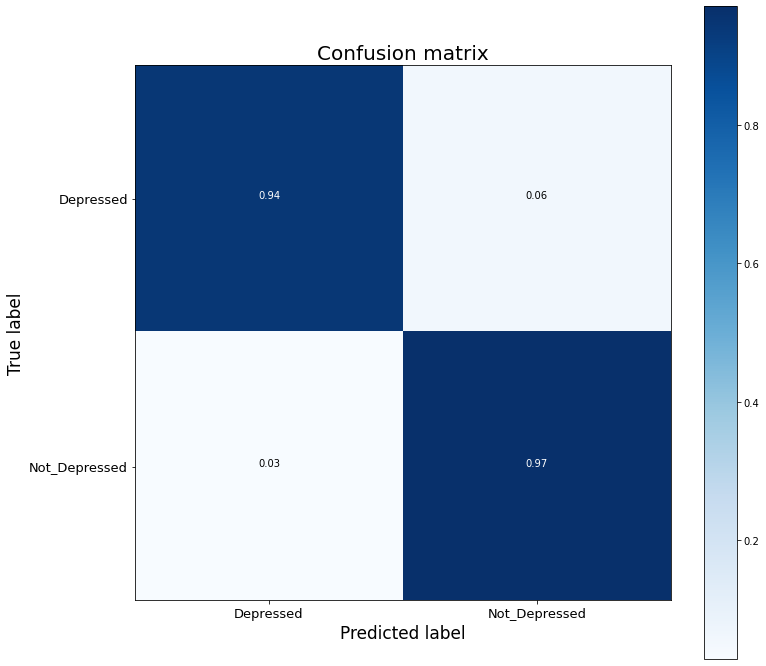

CPU times: user 526 ms, sys: 15.8 ms, total: 542 ms
Wall time: 541 ms


In [ ]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
plt.show()

In [ ]:
print(classification_report(y_test_1d, y_pred_1d))

               precision    recall  f1-score   support

    Depressed       0.97      0.94      0.96     53158
Not_Depressed       0.95      0.97      0.96     52730

     accuracy                           0.96    105888
    macro avg       0.96      0.96      0.96    105888
 weighted avg       0.96      0.96      0.96    105888



In [ ]:
accuracy_score(y_test_1d, y_pred_1d)

0.9580594590510728

In [ ]:
model.save("/content/drive/My Drive/TKFOLD1/Trigram_Updarted.h5")
w2v_model.save("/content/drive/My Drive/TKFOLD1/Trigram_Updated_W2V1.h5")
pickle.dump(tokenizer, open("/content/drive/My Drive/TKFOLD1/Trigram_Updated_Tokenizer1.pkl", "wb"), protocol=0)
pickle.dump(encoder, open("/content/drive/My Drive/TKFOLD1/Trigram_Updated_Encoder1.pkl", "wb"), protocol=0)

2020-07-28 03:15:41,399 : INFO : saving Word2Vec object under /content/drive/My Drive/TKFOLD1/Trigram_Updated_W2V1.h5, separately None
2020-07-28 03:15:41,400 : INFO : storing np array 'vectors' to /content/drive/My Drive/TKFOLD1/Trigram_Updated_W2V1.h5.wv.vectors.npy
2020-07-28 03:15:42,141 : INFO : not storing attribute vectors_norm
2020-07-28 03:15:42,142 : INFO : storing np array 'syn1neg' to /content/drive/My Drive/TKFOLD1/Trigram_Updated_W2V1.h5.trainables.syn1neg.npy
2020-07-28 03:15:48,457 : INFO : not storing attribute cum_table
/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
2020-07-28 03:15:48,595 : INFO : saved /content/drive/My Drive/TKFOLD1/Trigram_Updated_W2V1.h5
